# Stock Option NPV Calculator

This tool uses a Monte Carlo simulation to determine the net present value of stock options with a given expiry time, strike price, and model of the potential future trajectory of the underlying share price. To use the model, specify



1.   **Today's share price** - for a private company, this can be your estimate of the price that the shares could be sold for if the company had a liquidity event such as an exit.
2.   **Option strike price** - at what price can the options be sold?
3.   **Growth rate IQR** - this is the 25th and 75th percentile expected growth rate of the share price over the coming years. The model will run simulations estimating the future share price by applying a normal distribution that has these percentile values.
4.   **Growth rate limits** - because a normal distribution can include extremely low or high outlier values, we set a minimum and maximum limit on the growth rate and clamp the normal distribution so that it does not contain values outside of these limits. While this clamped distribution is not technically a normal distribution, we find the simulation is more realistic with limits in place, because most companies do have a likely lower and upper bound on their share price growth rate.
5.   **Target NPV*** - the target net present value of the stock options. Setting this target allows the model to search for the number of stock options that you should grant with the above-mentioned assumptions about share price, strike price, and growth, to achieve a given net present value. If your goal is to give an employee $50,000 of additional income from stock options in your company, then set the Target NPV to 50_000 and the model will do the rest.
6.   **Discount rate** - every growth scenario should be discounted to reflect the riskless growth rate of money that could otherwise be invested in government bonds or other riskless assets. Setting a discount rate of 5%, or to a value that reflects what rate of return you could earn by purchasing a guaranteed bank deposit, is probably the right approach.


In [4]:
# Generic Stock Option Pricing Calculator
#
# Copyright 2024 MailChannels Corporation
# All Rights Reserved
#
# This source code is placed in the public domain.

import functools
import numpy as np


SHARE_PRICE = 5.93 #@param {type: "number"}
STRIKE_DISCOUNT = 10 #@param {type: "number", min: 0, max: 100}
STRIKE_PRICE = SHARE_PRICE * (1 - STRIKE_DISCOUNT/100)
DISCOUNT_RATE = 0.05 #@param {type: "number"}
TARGET_NPV = 82500 #@param {type: "number"}
SHARE_GROWTH_LOW_PCT = 0 #@param {type: "number"}
SHARE_GROWTH_HIGH_PCT = 25 #@param {type: "number"}
SHARE_GROWTH_MIN_PCT = -20 #@param {type: "number"}
SHARE_GROWTH_MAX_PCT = 55 #@param {type: "number"}
YEARS = 5 #@param {type: "number"}
GROWTH_IQR = (SHARE_GROWTH_LOW_PCT/100,SHARE_GROWTH_HIGH_PCT/100)
GROWTH_LIMITS = (SHARE_GROWTH_MIN_PCT/100, SHARE_GROWTH_MAX_PCT/100)


def quick_npv(num_options):
    return stock_option_npv(num_options, SHARE_PRICE, STRIKE_PRICE, GROWTH_IQR, GROWTH_LIMITS, risk_free_rate=DISCOUNT_RATE)

def quick_options(target_npv):
    return options_for_target_npv(target_npv, SHARE_PRICE, STRIKE_PRICE, GROWTH_IQR, GROWTH_LIMITS, risk_free_rate=DISCOUNT_RATE)

@functools.lru_cache(maxsize=None)
def iqr_distribution(P25, P75, min_val, max_val, size=100000):
    """
    Generate a normal distribution with a given 25th and 75th percentile value and filter out values outside the specified range.
    Ensures the returned distribution has the desired number of samples.

    Args:
      P25:   25th percentile value
      P75:   75th percentile value
      size:  number of samples
      min_val:   minimum value; values below this will be discarded
      max_val:   maximum value

    Returns:
      distribution: Generated and filtered distribution with the desired number of samples
    """
    # Calculate mean (μ) and standard deviation (σ)
    mu = (P25 + P75) / 2
    sigma = (P75 - P25) / (2 * 0.674)

    # Initialize an empty list to hold the valid samples
    valid_samples = []

    # Generate and filter samples until we reach the desired size
    more = size
    while len(valid_samples) < size:
        # Generate the normal distribution
        distribution = np.random.normal(mu, sigma, more)

        # Filter out values outside the specified range
        filtered_distribution = distribution[(distribution >= min_val) & (distribution <= max_val)]

        # Add the valid samples to the list
        valid_samples.extend(filtered_distribution)

        more = int(1.1 * (size / len(valid_samples)) * (size - len(valid_samples)))

    # Trim the list to the desired size
    valid_samples = valid_samples[:size]
    return np.array(valid_samples)

@functools.lru_cache(maxsize=None)
def stock_option_npv(num_options, current_price, strike_price, growth_rate_iqr, growth_rate_limits, risk_free_rate=0.05, num_simulations=100000, num_years=YEARS):
    """
    Find the net present value of a stock option.

    Args:
      num_options:     Number of stock options
      current_price:   Current share price
      strike_price:    Strike price of options
      growth_rate_iqr: Intraquartile range (tuple) of the annual growth rate of the share price
      risk_free_rate:  The risk-free growth rate such as the treasury bond yield
      num_simulations: Number of simulations to run (defaults to 100,000)
      num_years:       Number of years after which to simulate exercising the options

    Returns:

    """
    # Calculate the lower and upper bounds of the growth rate based on the IQR
    growth_rate_lower = growth_rate_iqr[0]
    growth_rate_upper = growth_rate_iqr[1]

    # Generate random growth rates within the IQR range for each simulation
    growth_rates = iqr_distribution(growth_rate_lower, growth_rate_upper, growth_rate_limits[0], growth_rate_limits[1], size=num_simulations)

    # Calculate the share prices at the end of the 5-year period for each simulation
    future_prices = current_price * (1 + growth_rates) ** num_years

    # Calculate the payoff for each simulation
    payoffs = np.maximum(future_prices - strike_price, 0)

    # Calculate the expected payoff by taking the average of all simulations
    expected_payoff = np.median(payoffs)

    # Calculate the present value of the expected payoff using the risk-free rate
    npv = expected_payoff * num_options / (1 + risk_free_rate) ** num_years

    return npv

@functools.lru_cache(maxsize=None)
def options_for_target_npv(target_npv, current_price, strike_price, growth_rate_iqr, growth_rate_limits, risk_free_rate=0.05, num_simulations=100000, num_years=YEARS, tolerance=0.01):
    """
    Find the number of options required to achieve a target net present value.

    Args:
      target_npv:       The desired net present value of the stock option
      current_price:    The current share price
      strike_price:     The strike price of the option
      growth_rate_iqr:  Intraquartile range (tuple) of the annual growth rate of the share price
      risk_free_rate:   The risk-free growth rate such as the treasury bond yield
      num_simulations:  Number of simulations to run (defaults to 100,000)
      num_years:        Number of years after which to simulate exercising the options
      tolerance:        The tolerance value for ending our binary search

    Returns:

    """
    # Define the range of possible number of options
    min_options = 1
    max_options = 1000000

    while min_options <= max_options:
        # Calculate the midpoint of the range
        num_options = (min_options + max_options) // 2

        # Calculate the NPV for the current number of options
        npv = stock_option_npv(num_options, current_price, strike_price, growth_rate_iqr, growth_rate_limits, risk_free_rate, num_simulations, num_years)

        # Check if the calculated NPV is within the tolerance range of the target NPV
        if abs(npv - target_npv) < tolerance:
            return num_options
        elif npv < target_npv:
            min_options = num_options + 1
        else:
            max_options = num_options - 1

    return num_options

In [5]:
grant_size = options_for_target_npv(TARGET_NPV, SHARE_PRICE, STRIKE_PRICE, GROWTH_IQR, GROWTH_LIMITS, DISCOUNT_RATE)

print(f"To achieve an NPV of ${TARGET_NPV:,.0f} the grant size should be {grant_size:,.0f} shares at ${STRIKE_PRICE:,.2f}/share")

def round_to_nice_number(x):
    nice_numbers = [1000, 2500, 5000, 10000, 25000, 50000, 100000]
    return min(nice_numbers, key=lambda num: abs(x - num))

grant_size = round_to_nice_number(grant_size)
print(f"But we'll use a nice round number: {grant_size:,.0f}, resulting in an NPV of ${quick_npv(grant_size):,.0f}")


To achieve an NPV of $82,500 the grant size should be 18,392 shares at $5.34/share
But we'll use a nice round number: 25,000, resulting in an NPV of $112,136


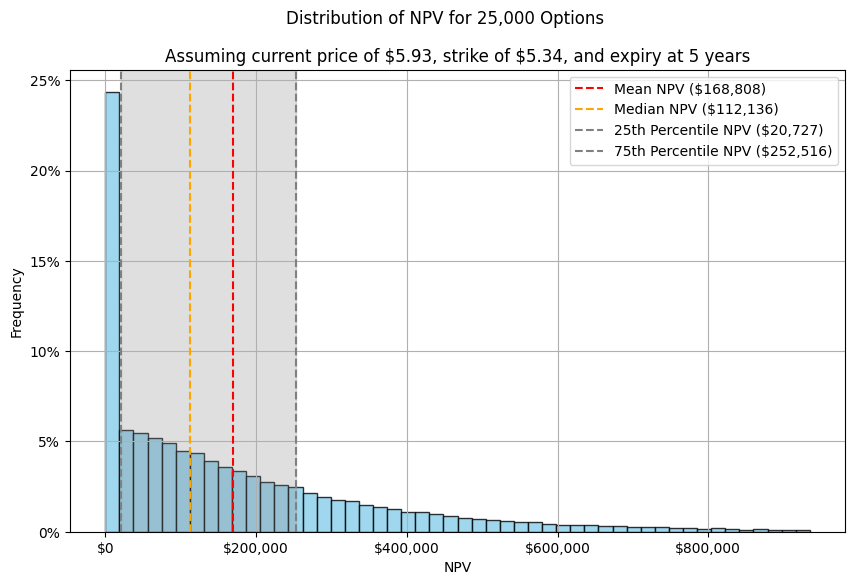

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def stock_option_npv_distribution(num_options, current_price, strike_price, growth_rate_iqr, growth_rate_limits, risk_free_rate=0.05, num_simulations=100000, num_years=5):
    # Calculate the lower and upper bounds of the growth rate based on the IQR
    growth_rate_lower = growth_rate_iqr[0]
    growth_rate_upper = growth_rate_iqr[1]
    growth_rate_min   = growth_rate_limits[0]
    growth_rate_max   = growth_rate_limits[1]

    # Generate random growth rates within the IQR range for each simulation
    growth_rates = iqr_distribution(growth_rate_lower, growth_rate_upper, growth_rate_min, growth_rate_max, size=num_simulations)

    # Calculate the share prices at the end of the 5-year period for each simulation
    future_prices = current_price * (1 + growth_rates) ** num_years

    # Calculate the payoff for each simulation
    payoffs = np.maximum(future_prices - strike_price, 0)

    # Calculate the NPV for each simulation
    npvs = payoffs * num_options / (1 + risk_free_rate) ** num_years

    return npvs

# Set the parameters
num_options = grant_size

# Calculate the NPVs for each simulation
npvs = stock_option_npv_distribution(num_options, SHARE_PRICE, STRIKE_PRICE, GROWTH_IQR, GROWTH_LIMITS)

npv_mean = np.mean(npvs)
npv_median = np.median(npvs)
npv_25th = np.quantile(npvs, 0.25)
npv_75th = np.quantile(npvs, 0.75)

count = len(npvs)

# Plot the histogram of NPVs
plt.figure(figsize=(10, 6))
plt.hist(npvs, bins=50, alpha=0.8, color='skyblue', edgecolor='black')
plt.axvline(npv_mean, color='red', linestyle='--', label=f'Mean NPV (${npv_mean:,.0f})')
plt.axvline(npv_median, color='orange', linestyle='--', label=f'Median NPV (${npv_median:,.0f})')
plt.axvline(npv_25th, color='grey', linestyle='--', label=f'25th Percentile NPV (${npv_25th:,.0f})')
plt.axvline(npv_75th, color='grey', linestyle='--', label=f'75th Percentile NPV (${npv_75th:,.0f})')
plt.axvspan(npv_25th, npv_75th, color='grey', alpha=0.25)

plt.gca().xaxis.set_major_formatter(lambda x,pos: f"${x:,.0f}")
plt.gca().yaxis.set_major_formatter(lambda x,pos: f"{100*x/count:,.0f}%")


plt.xlabel('NPV')
plt.ylabel('Frequency')
plt.title(f'Assuming current price of \${SHARE_PRICE:,.2f}, strike of \${STRIKE_PRICE:,.2f}, and expiry at {YEARS:,.0f} years')
plt.suptitle(f'Distribution of NPV for {num_options:,.0f} Options')
plt.legend()
plt.grid(True)
plt.show()

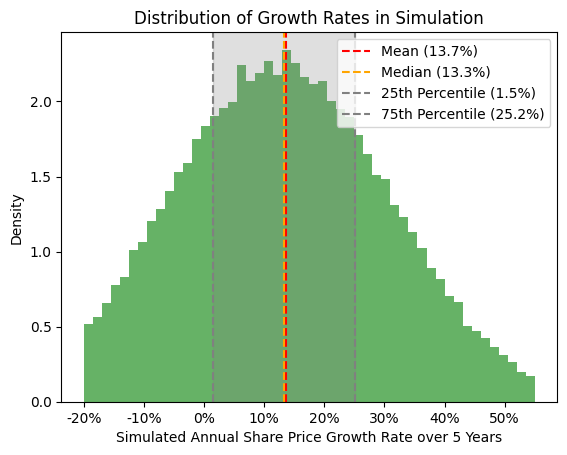

In [7]:
# Plot the distribution
distribution = iqr_distribution(GROWTH_IQR[0], GROWTH_IQR[1], GROWTH_LIMITS[0], GROWTH_LIMITS[1], size=100000)
plt.hist(distribution, bins=50, density=True, alpha=0.6, color='g')
plt.title('Distribution of Growth Rates in Simulation')
plt.gca().xaxis.set_major_formatter(lambda x,pos: f"{100*x:,.0f}%")
plt.gca().yaxis.set_major_formatter(lambda x,pos: f"{x:,.1f}")
plt.axvline(distribution.mean(), color='red', linestyle='--', label=f'Mean ({100*distribution.mean():,.1f}%)')
plt.axvline(np.quantile(distribution,0.5), color='orange', linestyle='--', label=f'Median ({100*np.quantile(distribution,0.5):,.1f}%)')
plt.axvline(np.quantile(distribution,0.25), color='grey', linestyle='--', label=f'25th Percentile ({100*np.quantile(distribution,0.25):,.1f}%)')
plt.axvline(np.quantile(distribution,0.75), color='grey', linestyle='--', label=f'75th Percentile ({100*np.quantile(distribution,0.75):,.1f}%)')
plt.axvspan(np.quantile(distribution,0.25), np.quantile(distribution,0.75), color='grey', alpha=0.25)
plt.xlabel(f'Simulated Annual Share Price Growth Rate over {YEARS} Years')
plt.ylabel('Density')
plt.legend()
plt.show()

In [9]:
# Generate the option grants for the whole company by reading in a table of employee name and target npv.
# Assume there is a column "full_name" and "equity_npv"
import pandas as pd
employee_table = pd.read_csv("ESOP NPV Calculator.csv")

round_options = lambda npv: round_to_nice_number(quick_options(npv)) if npv else 0
employee_table['option_count'] = employee_table['npv'].apply(round_options)
employee_table['option_npv'] =   employee_table['option_count'].apply(quick_npv)

employee_table[['full_name', 'monthly_pay', 'annual_pay', 'bucket',
                'npv_rate', 'npv', 'option_count', 'option_npv']].to_csv("ESOP NPV Calculator Final.csv")


In [10]:
quick_npv(50000)

224272.0044342242